In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import itertools
import time
import torch
import pylab as plt
# %matplotlib inline

from agentic_dqn import DQN_AGENT_priotized_buffer as agent
from agentic_dqn import PrioritizedReplayBuffer as prio_buffer
from utils import running_mean
import logging
import imageio
import os

In [2]:
class DiscreteActionWrapper(gym.ActionWrapper):
    def __init__(self, env: gym.Env, bins=5):
        """A wrapper for converting a 1D continuous actions into discrete ones.
        Args:
            env: The environment to apply the wrapper
            bins: number of discrete actions
        """
        assert isinstance(env.action_space, spaces.Box)
        super().__init__(env)
        self.bins = bins
        self.orig_action_space = env.action_space
        self.action_space = spaces.Discrete(self.bins)

    def action(self, action):
        """discrete actions from low to high in 'bins'
        Args:
            action: The discrete action
        Returns:
            continuous action
        """
        return self.orig_action_space.low + action / (self.bins - 1.0) * (
            self.orig_action_space.high - self.orig_action_space.low
        )


In [3]:
seed1 = 7489
seed2 = 1312

SEEDS_TEST = [291, 292, 293, 294, 295] 
torch.manual_seed(seed1)
np.random.seed(seed1)

In [4]:
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

### Test in env 

In [5]:
env_name = 'Pendulum-v1'
#env_name = 'CartPole-v0'
#env_name = 'LunarLander-v3'

env = gym.make(env_name,render_mode="rgb_array")
if isinstance(env.action_space, spaces.Box):
    env = DiscreteActionWrapper(env,5)

ac_space = env.action_space
o_space = env.observation_space
print(ac_space)
print(o_space)
print(list(zip(env.observation_space.low, env.observation_space.high)))
alpha = 0.2
beta = 0.4

config = {
            "eps": 0.05,  # Epsilon in epsilon greedy policies
            "discount": 0.95,
            "buffer_size": int(1e5),
            "batch_size": 128,
            "learning_rate": 0.0001,
            "update_target_every": 128,
            "use_target_net": True,
            "prioritized_replay_eps": 1e-6,
        }

Discrete(5)
Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
[(np.float32(-1.0), np.float32(1.0)), (np.float32(-1.0), np.float32(1.0)), (np.float32(-8.0), np.float32(8.0))]


In [6]:
use_target = True
target_update = 20
q_agent = agent(o_space, ac_space, discount=0.95, eps=0.2, 
                   use_target_net=use_target, update_target_every= target_update, alpha =  alpha, beta = beta, config = config)

In [7]:
ob,_info = env.reset()
q_agent.Q.predict(ob)


stats = []
losses = []

In [8]:
"""max_episodes=500
max_steps=500 
for i in range(max_episodes):
    # print("Starting a new episode")    
    total_reward = 0
    ob, _info = env.reset()
    for t in range(max_steps):
        done = False        
        a = q_agent.act(ob)
        (ob_new, reward, done, trunc, _info) = env.step(a)
        total_reward+= reward
        q_agent.store_transition((ob, a, reward, ob_new, done))            
        ob=ob_new        
        if done: break    
    losses.extend(q_agent.train(32))
    stats.append([i,total_reward,t+1])    
    
    if ((i-1)%20==0):
        print("{}: Done after {} steps. Reward: {}".format(i, t+1, total_reward))"""


stats, losses = q_agent.train(env = env, max_episodes=400)

1: Done after 500 steps. Reward: -4459.661295575348 beta: 0.4021428571428572 frames: 1000
21: Done after 500 steps. Reward: -3273.6674260854857 beta: 0.4235714285714286 frames: 11000
41: Done after 500 steps. Reward: -2976.878595196401 beta: 0.445 frames: 21000
61: Done after 500 steps. Reward: -3796.4211454961437 beta: 0.46642857142857147 frames: 31000
81: Done after 500 steps. Reward: -2451.537834524697 beta: 0.4878571428571429 frames: 41000
101: Done after 500 steps. Reward: -3462.932436060494 beta: 0.5092857142857143 frames: 51000
121: Done after 500 steps. Reward: -2185.110120191128 beta: 0.5307142857142857 frames: 61000
141: Done after 500 steps. Reward: -2883.9635065096672 beta: 0.5521428571428572 frames: 71000
161: Done after 500 steps. Reward: -2960.841834106806 beta: 0.5735714285714286 frames: 81000
181: Done after 500 steps. Reward: -2342.750541202487 beta: 0.595 frames: 91000
201: Done after 500 steps. Reward: -2559.1849515183912 beta: 0.6164285714285714 frames: 101000
221:

2025-01-22 22:04:03,070 - INFO -  mean sample time: 0.00605281101539731


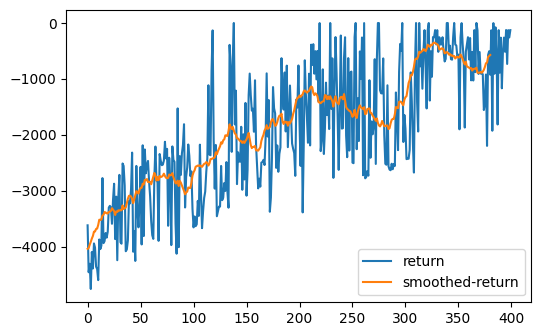

In [9]:
stats_np = np.asarray(stats)
losses_np = np.asarray(losses)
fig=plt.figure(figsize=(6,3.8))
plt.plot(stats_np[:,1], label="return")
plt.plot(running_mean(stats_np[:,1],20), label="smoothed-return")
plt.legend()

In [10]:
fig.savefig(f"DQN_withPER_{env_name}_training_w_target_{use_target}-update-{target_update}_alpha{alpha}_beta{beta}.pdf")

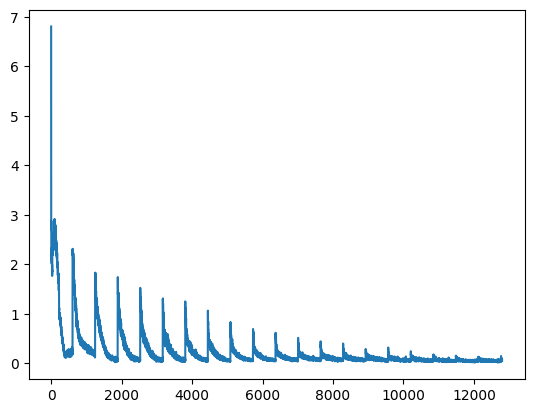

In [11]:
plt.figure()
plt.plot(losses_np)

In [12]:
q_agent.buffer.size

100000

# Evaluate 

In [13]:
env_eval = gym.make(env_name, render_mode="human")
if isinstance(env.action_space, spaces.Box):
    env_eval = DiscreteActionWrapper(env_eval,5)

In [14]:
test_stats = []
episodes=50
max_steps=500
env_ = env    # without rendering
#env_ = env_eval # with rendering

for i in range(episodes):
    total_reward = 0
    ob, _info = env_.reset()
    for t in range(max_steps):
        done = False        
        a = q_agent.act(ob, eps=0.0)
        (ob_new, reward, done, trunc, _info) = env_.step(a)
        total_reward+= reward
        ob=ob_new        
        if done: break    
    test_stats.append([i,total_reward,t+1]) 

In [15]:
test_stats_np = np.array(test_stats)
print(np.mean(test_stats_np[:,1]), "+-", np.std(test_stats_np[:,1]))

-354.7150049190095 +- 818.0181127245469


In [16]:
test_episodes = len(SEEDS_TEST)
test_rewards = []

max_steps = 1000

for episode in range(test_episodes):
    state = env.reset(seed = SEEDS_TEST[episode])
    state = state[0] if isinstance(state, tuple) else state
    done = False
    total_reward = 0
    frames = []
    
    for t in range(max_steps):
        frame = env.render()
        if frame is not None:
            frames.append(frame)
        action = q_agent.act(observation= state)  # Fully greedy policy
        next_state, reward, done, truncated, _ = env.step(action)
        state = next_state
        total_reward += reward
        print(f"Step {t+1}, Total Reward: {total_reward}", end="\r")
        if done: break
    
    test_rewards.append(total_reward)
    print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
    
    if frames:
        os.makedirs(f"{env_name}/test_gifs", exist_ok=True)
        print("making gif")
        _imageio.mimsave(f"{env_name}/test_gifs/test_episode_{episode+1}_{env_name}.gif", frames, fps=30)
        print("gif made")

env.close()



Test Episode 1, Total Reward: -779.2014544759647
making gif


NameError: name '_imageio' is not defined